# **Text Vectorization II**

---
### Natural Language Processing
Date: Nov 16, 2022

Author: Lorena Calvo-Bartolomé (lcalvo@pa.uc3m.es)

Version 1.0

---
This notebook is based on the Gensim documentation and tutorials, as well as on Daniel Voigt Godoy's book "Deep Learning with Pytorch Step-by-Step, Volume III: Sequences \& NLP".

Our goal here is to provide a basic overview of the following text vectorization techniques:


*   Word2Vec
*   GloVe
*   FastText
*   ELMo

as well as how to use them to solve a Text Classification task.

Veremos algunos de los métodos más comunes de vectorización y usaremos dichas representaciones de los datos para resolver la tarea de clasificación de sentimientos.

In [1]:
%pip install gensim==4.2.0 pqkmeans

  Using cached pqkmeans-1.0.5.tar.gz (161 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pipe-2.0-py3-none-any.whl (8.8 kB)
  Using cached texmex_python-1.0.0-py3-none-any.whl
  Using cached lshash3-0.0.8.tar.gz (9.4 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached bitarray-2.6.0-cp310-cp310-win_amd64.whl (110 kB)
  Running setup.py clean for lshash3
Failed to build pqkmeans lshash3
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pqkmeans (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [92 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\pqkmeans
      copying pqkmeans\evaluation.py -> build\lib.win-amd64-cpython-310\pqkmeans
      copying pqkmeans\__init__.py -> build\lib.win-amd64-cpython-310\pqkmeans
      creating build\lib.win-amd64-cpython-310\test
      copying test\__init__.py -> build\lib.win-amd64-cpython-310\test
      creating build\lib.win-amd64-cpython-310\pqkmeans\clustering
      copying pqkmeans\clustering\bkmeans.py -> build\lib.win-amd64-cpython-310\pqkmeans\clustering
      copying pqkmeans\clustering\cpp_implemented_clustering_sample.py -> build\lib.win-amd64-cpython-310\pqkmeans\clustering
      copying pqkmeans\clustering\pqkmeans.py -> build\lib.win-amd64-cp

In [2]:
# Instalamos las librerías necesarias para el desarrollo de la práctica

# Common imports 
import os
import numpy as np
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import scipy
import gc
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import contractions
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, word_tokenize
import colored
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.metrics import accuracy_score
from numpy import array  
from numpy import argmax  
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import OneHotEncoder
from gensim.models import KeyedVectors  


# Figures plotted inside the notebook
%matplotlib inline 
# High quality figures
%config InlineBackend.figure_format = 'retina' 
# Figures style
plt.style.use('seaborn-whitegrid')
sns.set_style("darkgrid")
sns.color_palette("deep")
# Figues size
plt.rcParams['figure.figsize'] = [8, 6]

# Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',module='compress_fasttext')

In [3]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
path_to_folder = 'C:/Users/José/Desktop/Master - CIII/1ºCuatrimestre/2ºSemicuatrimestre/Códigos - Python/Procesamiento del Lenguaje Natural/Lab1'  # UPDATE THIS ACCORDING TO WHERE YOU WANT TO SAVE THE FILES!!!!

In [5]:
# Change to assignment directory
os.chdir(path_to_folder) 

## **1. Data preparation**
---


For this second text vectorization notebook, we will keep working with the **IMDB Dataset of 50K Movie Reviews**. Since we already carried out all the dataset preparation in the previous notebook, we will just load the the dataframe that we saved.

In [6]:
import pickle

def unpickler(file: str):
    """Unpickle file"""
    with open(file, 'rb') as f:
        return pickle.load(f)

corpus_df = unpickler("corpus_df_imbdb.pickle")
print(len(corpus_df))

15000


In [7]:
corpus_df

,review,sentiment,clean_review,binary_sentiment
33003,"Set in Paris in the year 1910, a retired old r...",positive,"[set, paris, retired, old, rich, opera_singer,...",1
12172,"Basic structure of a story: Beginning, Middle,...",negative,"[basic, structure, story, beginning_middle, en...",0
5192,"An odd, willfully skewed biopic of Dyan Thomas...",negative,"[odd, willfully, skewed, biopic, dyan, thomas,...",0
32511,"Okay, you have:<br /><br />Penelope Keith as M...",negative,"[okay, miss, b, b, e, backbone, england, kille...",0
43723,The larger-than-life figures of Wyatt Earp and...,positive,"[larger_life, figure, wyatt_earp, bat, masters...",1
...,...,...,...,...
16645,"6/10 Acting, not great but some good acting.<b...",negative,"[6, 10, acting, great, good, acting, 4_10, dir...",0
14615,"Perhaps the biggest waste of production time, ...",negative,"[perhaps, biggest, waste, production, time, mo...",0
36865,Hilarious!! I would have sworn Ed Wood wrote t...,negative,"[hilarious, would, sworn, ed_wood, wrote, terr...",0
20865,This unsung quiet gem tells the true story of ...,positive,"[unsung, quiet, gem, tell, true, story, pow, e...",1


##### **Exercise 1**

Create a Gensim corpus and obtain its Gensim dictionary. With the latter, save the vocabulary of the corpus as a list. Store the Gensim corpus in a variable named ``corpus``, the Gensim dictionary in a variable named ``D``, and the vocabulary in a variable named ``vocab``.

**Hint:** Make use of the Gensim dictionary' method ``token2id`` for obtaining the vocabulary list.

In [8]:
# <SOL>

corpus = []

for i in range (15000):
    corpus.append(corpus_df['clean_review'].values[i])

D = Dictionary(corpus)


vocab = []

for k, v in D.token2id.items():
    vocab.append(k)

# </SOL>

print('\n============= First 10 words in the vocabulary =============')
print(vocab[0:20])


============= First 10 words in the vocabulary =============
['acting', 'animated', 'animation', 'away', 'beautiful', 'butler_edgar', 'cat', 'come', 'computer_animation', 'countryside', 'couple', 'cult', 'day', 'death', 'decides', 'disney_animated', 'duchess', 'edgar', 'edgy', 'entertaining']


Let's also save the sentiment of the review in a NumPy array for later use.

In [9]:
Y = corpus_df['binary_sentiment'].values

## **2. Word2Vec**
---


We will use [Gensim's implementation of Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html), which supports both the skip-gram and CBOW models, with either hierarchical softmax or negative sampling. Furthermore, Gensim contains a collection of functions for the exploitation of pre-trained embeddings, which can be either embeddings developed by us or pre-trained models on big corpora.

### *2.1. Implementation of Word2Vec in Gensim*

Word2Vec models require a lot of text, e.g., the entire Wikipedia corpus. Nevertheless, we will demonstrate the principles using a small example from our IMDB dataset.

Gensim's Word2Vec expects a sequence of sentences (``sentences``) as its input where each sentence is a list of words:

```
sentences = [['This', 'is', 'the', 'first', 'sentence'], ['This', 'is', 'the', 'second', 'sentence']]
```

In addition, some of the most important parameters that we may wish to configure are the following:

* `vector_size`: The dimensionality of the word vectors, i.e.,  the embedding size. The default is **100**.
* `window`: The window size, i.e., the number of adjacent words that are considered in the same context as the target word. The default is **5**.
* `min_count`: Ignores all words with a total frequency lower than this.
* `sg`: Training algorithm: 1 for skip-gram; otherwise CBOW.

Keeping the input as a Python built-in list is convenient, but can use up a lot of RAM when the input is large. Gensim only requires the input to provide sentences sequentially, when iterated over. Hence, we can use the same principle that we utilized in the first notebook of this tutorial at ``2.5. Memory efficient computation``.

Usaremos la implementación de Word2Vec de Gensim que admite modelos tanto para skip-gram (predicción de palabras contexto a partir de una palabra central) y cbow (predicción de la palabra central a partir de la suma de un determinado número de palabras contextuales).

Además, Gensim permite el uso de modelos de embeddings pre-entrenados (ya sean modelos entrenados por nosotros mismos o algunos pre-entrenados con un corpus muy grande).

##### **Exercise 2**

Implement a class ``IterableSentence_fromfile`` to create an iterator that yields one sentence (list of utf8 words) after another from the file ``"imdb_lemmas_clean.txt"``.

Use the sentence iterator to create a Word2Vec skip-gram model named ``model_w2v`` with vector size **200** and window size **5**. Use a seed of **42**.

In [10]:
class IterableSentence_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

In [11]:
docss = IterableSentence_fromfile('imdb_lemmas_clean.txt')

sentece_iterator = []
for i in docss:
    sentece_iterator.append(i)

In [12]:
%%time
from gensim.models import Word2Vec

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
# <SOL>
model_w2v = Word2Vec(sentences=sentece_iterator, vector_size=200, window=5, seed=42, min_count=3)
model_w2v.save("word2vec.model")
# </SOL>

In [14]:
# entrenaremos el modelo de wv con nuestras sentence (con cada token tomado aparte) de forma que las codificaciones de las palabras
# se representarán en un vector de 200 posiciones buscando juntas a nivel dimensional, las que más similitud tengan entre sí asociado
# a la ventana de 5 posiciones que usamos para el entrenamiento

Once the model is trained, it is accessible via the ``wv`` attribute, which is the actual word vector model in which queries can be made.

We can see the learned vocabulary of the model through the dictionary ``key_to_index``, that is, the target words for which we have calculated an embedding, as well as the corresponding embeddings for these words, as follows:

In [15]:
print('\n============= Word2Vec vocabulary =============')
words = list(model_w2v.wv.key_to_index)
print(words[0:50])
print('\n============= Embedding of the first word =============')
print(model_w2v.wv[words[0]])


============= Word2Vec vocabulary =============
['movie', 'wa', 'film', 'one', 'like', 'ha', 'good', 'would', 'time', 'character', 'story', 'get', 'see', 'make', 'really', 'even', 'doe', 'scene', 'well', 'people', 'also', 'could', 'great', 'way', 'first', 'show', 'bad', 'much', 'made', 'thing', 'think', 'go', 'know', 'life', 'watch', 'many', 'two', 'actor', 'say', 'acting', 'look', 'love', 'plot', 'best', 'never', 'end', 'little', 'still', 'seen', 'find']

============= Embedding of the first word =============
[ 0.91707784  0.7602022   0.7280788   0.34462705 -0.0106099   0.57715696
 -0.9477037   0.5106936  -0.3242036  -0.5330305  -0.82149214 -0.03482946
  0.3707641   0.9999071  -0.4543796  -0.61246806  1.0185378  -1.1112208
 -0.08051472  0.42156395  0.27049562 -0.16438161 -0.2618215   1.1848447
  0.97228473  0.7831027  -0.44808242  1.8784804  -0.6677941  -1.5864484
 -0.4699453  -0.06643493 -0.17892444 -0.51481986  0.01449901 -0.37776765
  1.4541941   0.8084948   0.05854331  1.1350347

We can save the trained model by calling the ``save()`` function, and we can load it again by calling the ``load()`` method. 

In [16]:
model_w2v.save("model_w2v_imbd_sampling03.model")

# This function will load the model, but we will not be using it here
#model_w2v = Word2Vec.load("model_w2v_imbd_sampling03.model")

Since we are not going to keep with the training at this moment, we do not need the full model state anymore. Hence, we can store the words and their trained embeddings and load them back as ``KeyedVectors``, which is essentially a mapping between keys and vectors. This results in a much smaller and faster object that can be mapped for lightning-fast loading and sharing the vectors in RAM between processes.

In [17]:
# Store just the words + their trained embeddings.
word_vectors = model_w2v.wv
word_vectors.save("model_w2v_imbd_sampling03.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("model_w2v_imbd_sampling03.wordvectors", mmap='r')

Let's free the memory.



In [18]:
del model_w2v
gc.collect()

4

Since we have represented our words as numerical vectors, we can utilize the Euclidean distance (or cosine similarity) among two word vectors to measure the linguistic or semantic similarity of the corresponding words. To do this, Gensim provides the function ``most_similar`` which returns the most similar words from a given word.

In [19]:
wv.most_similar(positive="cinema")

[('documentary', 0.8786667585372925),
 ('masterpiece', 0.873993456363678),
 ('sci_fi', 0.862535297870636),
 ('argument_mine', 0.8590717911720276),
 ('today', 0.8576673269271851),
 ('gem', 0.8513367176055908),
 ('remake', 0.8499500751495361),
 ('entertainment', 0.8476877808570862),
 ('imdb_user', 0.8463624119758606),
 ('critic', 0.8441359400749207)]

In [20]:
wv.most_similar(positive="restaurant")

[('rory', 0.987978994846344),
 ('maid', 0.9878410696983337),
 ('waitress', 0.9875403046607971),
 ('blackie', 0.987206757068634),
 ('parker', 0.9871279001235962),
 ('mustache', 0.986574649810791),
 ('mentor', 0.9864062666893005),
 ('heroin', 0.9862452149391174),
 ('carl', 0.9858027696609497),
 ('restless', 0.9857977032661438)]

Representamos palabras que, representadas en las 200 dimensiones, su distancia euclidea es cercana a las palabras centrales que indicamos. Como vemos son palabras que se relacionan mucho entre sí.

We can also check the performance of our model by visualizing the embeddings. However, although embeddings are low-dimensional vectors, even 4 dimensions are too high to visualize. [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (*t-distributed Stochastic Neighbor Embedding*) solves this problem as it allows for visualizing high-dimensional data by reducing them to two or three-dimensional data. The technique takes in the embeddings (or any data) and aims at preserving as much as possible in 2 (or 3) dimensions the distances from the original space of the embedding dimension. This, therefore, helps us to get a feel for the space of word embedding.


Sklearn includes an implementation of [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) that we can easily use.

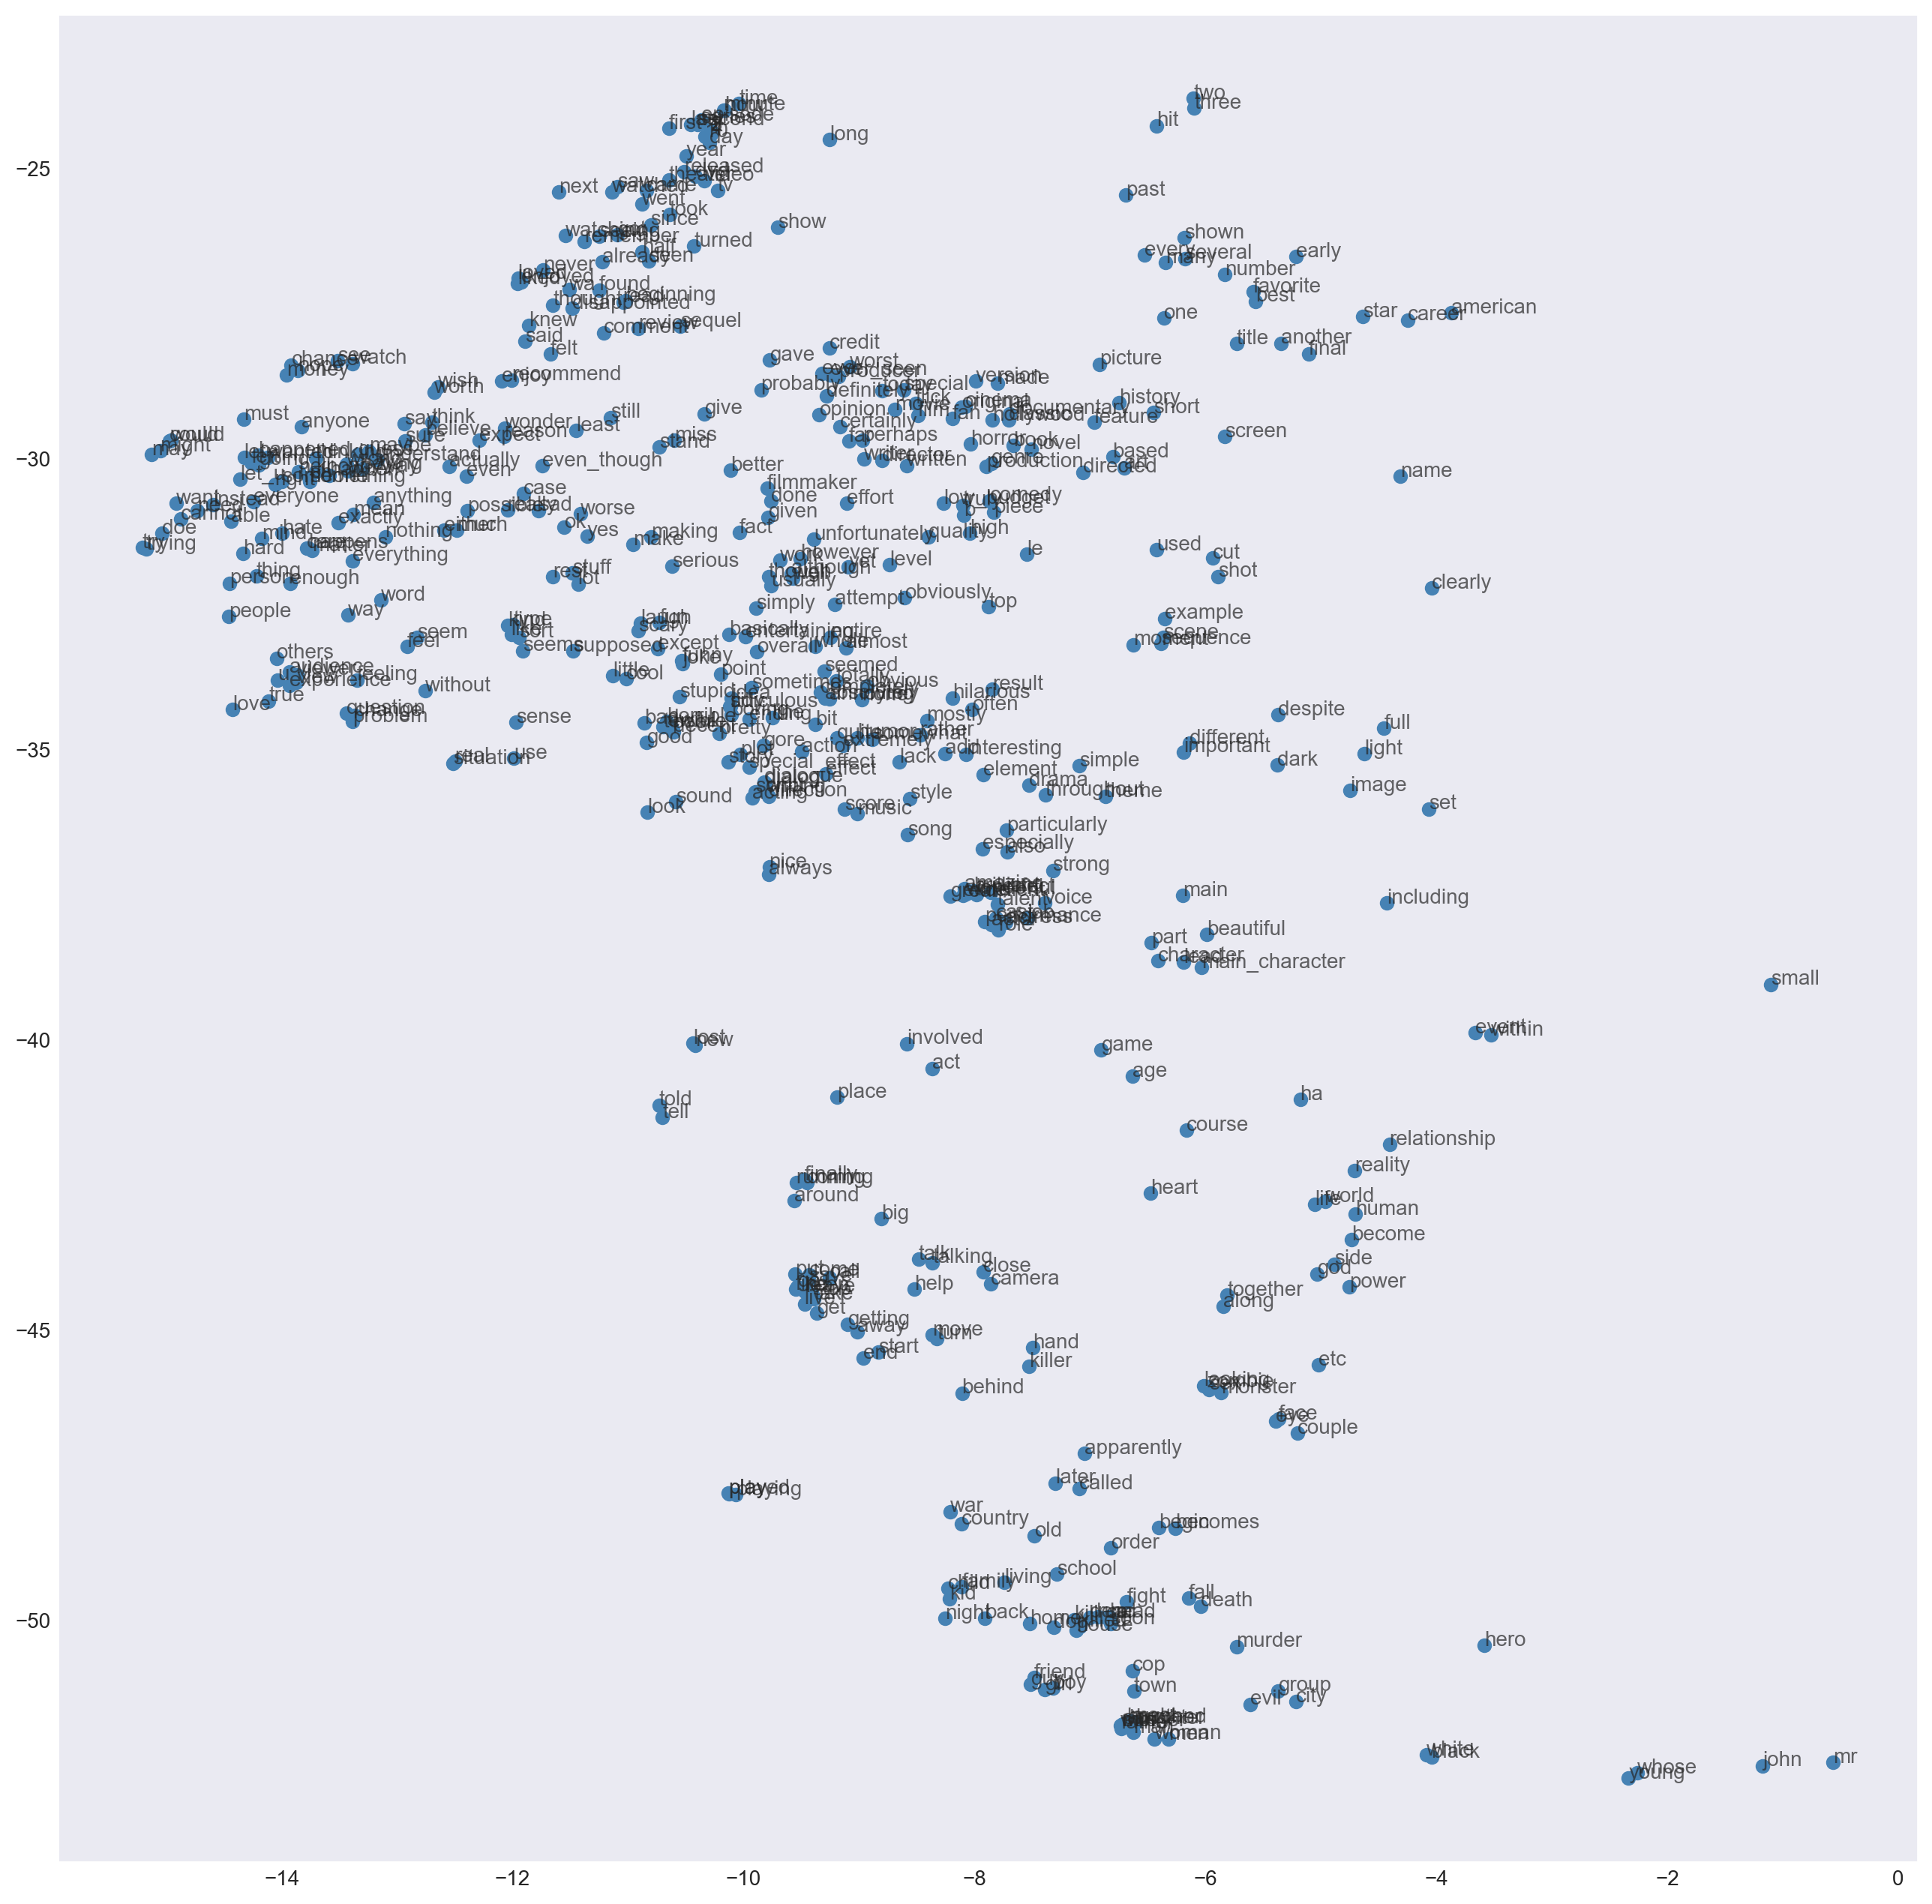

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

otra forma de ver si ha funcionado correctamente es plotear la representación de las palabras y ver si las cercanas entre sí cuadran/guardan relación. No podemos representar 200 dimensiones, por lo que usamos tsne para reducción de dimensionalidad y lo dejamos en 2 para plotear.

In [22]:
del embed_tsne
gc.collect()

30

From the above results, we can see that our word2vec model does not do a bad job, but it could still be improved. Certainly, we need to train on a much larger dataset to obtain a coherent embedding structure. 

Si bien los resultados proporcionados por el Word2Vec son relativamente buenos, necesitariamos un dataset mucho mayor para obtener un "embedding" con una estructura realmente coherente al completo.

### *2.2. Sentiment Analysis with ad-hoc trained Word2Vec embeddings*

Since our data contains reviews and not just words, we need to figure out a way to use the word vectors from the word2vec model to create a vector representation for an entire review. One simple solution to achieve this is to take the mean of all the word vectors present in the review. 

Since when we constructed our Word2Vec model we filtered out those words which did not have an overall frequency of 10, we may encounter that our reviews contain some words that are not in the vocabulary of the model, i.e., they are out-of-vocabulary words (OOV).

##### **Exercise 3**

Implement the function ``get_vocabulary_coverage`` which, given a ``KeyedVectors`` object and the Gensim dictionary associated with the reviews, calculates the vocabulary coverage of the model. Take into account the frequency with which the OOV words appear in the reviews.

Then, calculate the coverage of the Word2Vec model on the IMDB vocabulary.

In [ ]:
def get_vocabulary_coverage(model, gensim_dict):
  # <SOL>
  # TODO: Implement body
  # </SOL>
  return coverage

# <SOL>
# TODO: Use function "get_vocabulary_coverage" to calculate coverage and print result
# </SOL>

In [70]:
wv

In [26]:
wv.index_to_key

['movie',
 'wa',
 'film',
 'one',
 'like',
 'ha',
 'good',
 'would',
 'time',
 'character',
 'story',
 'get',
 'see',
 'make',
 'really',
 'even',
 'doe',
 'scene',
 'well',
 'people',
 'also',
 'could',
 'great',
 'way',
 'first',
 'show',
 'bad',
 'much',
 'made',
 'thing',
 'think',
 'go',
 'know',
 'life',
 'watch',
 'many',
 'two',
 'actor',
 'say',
 'acting',
 'look',
 'love',
 'plot',
 'best',
 'never',
 'end',
 'little',
 'still',
 'seen',
 'find',
 'work',
 'want',
 'give',
 'man',
 'come',
 'part',
 'better',
 'something',
 'lot',
 'director',
 'take',
 'ever',
 'real',
 'going',
 'play',
 'funny',
 'performance',
 'actually',
 'woman',
 'back',
 'guy',
 'watching',
 'another',
 'cannot',
 'girl',
 'nothing',
 'got',
 'seems',
 'role',
 'old',
 'thought',
 'quite',
 'fact',
 'comedy',
 'u',
 'though',
 'feel',
 'however',
 'point',
 'day',
 'world',
 'enough',
 'right',
 'every',
 'horror',
 'long',
 'interesting',
 'may',
 'kind',
 'least',
 'friend',
 'year',
 'always',
 'o

In [71]:
wv.getVectors().count()

AttributeError: 'KeyedVectors' object has no attribute 'getVectors'

In [63]:
len(vocab)

29780

AttributeError: 'dict' object has no attribute 'shape'

In [54]:
len(wv_vocab)

44816

In [51]:
len(vocab)

29780

##### **Exercise 4**

Implement the function ``get_review_vector`` which, given a ``KeyedVectors`` object, and a list of tokens representing a review returns the embedding vector for such a review by taking the average of the vectors of the words present in the given review. Ignore the OOV words.

Once you have the function, calculate the reviews' embedding vectors. Save them in a sparse matrix of dimensions $[n_{reviews}, e_{size}]$, where $e_{size}$ is the embedding size of the model.

In [ ]:
def get_review_vector(model, review):
  # <SOL>
  # TODO: Implement body
  # </SOL>
  return vec

# <SOL>
# TODO: Calculate embedding vectors for each review and save them in a sparse matrix
# </SOL>

##### **Exercise 5**
Classify the reviews based on the Word2Vec embeddings representation with an SVM classifier. Split the data into a $70:30$ ratio for training and test with a $42$ random_state and use ``GridSearchCV`` to find the best hyperparameters values (``C`` and ``kernel``) for the classifier. Consider the grid search of the parameter ``C`` between 1 and 10 in intervals of 2, and try out the ``rbf`` and the ``linear`` kernels. At last, evaluate the performance of the classifier based on  its mean accuracy on the given test data and labels (``score`` function of the SVM classifier).

In [ ]:
# <SOL>

# </SOL>

## *3. GloVe*

### *3.1. Pre-trained GloVe models in Gensim*

For a specific NLP task, training our own word vectors may be the optimal strategy. However, it may require a long time, a fast computer with plenty of RAM and disc space, and maybe some experience in fine-tuning the input data and training algorithm. Another option is to just utilize pre-trained word embeddings.

For example, Gensim includes functions to exploit a set of [pre-trained *embeddings*](https://github.com/RaRe-Technologies/gensim-data).

In [ ]:
from gensim import downloader

print(colored('\n============= Available pre-trained models in Gensim =============', 'blue'))
print(list(downloader.info()['models'].keys()))

As we can see above, many of the pretrained models provided by Gensim are GloVe models. The pretrained GloVe embeddings come in many sizes and shapes, with dimensions in the range $[25,30]$, and vocabularies varying between $400,000$ and $2,200,000$ words.

Let's use Gensim's downloader to get the ``glove-wiki-gigaword-50``, which is the smallest available GloVe model. It was trained on Wikipedia 2014 and Gigawords, contains $400,000$ vocabulary words and its embeddings have a dimension of $50$.

In [ ]:
glove = downloader.load('glove-wiki-gigaword-50')

print(f"The dictionary size is {glove.vectors.shape[0]}.\n\
        Each embedding has a dimension of {glove.vectors.shape[1]}")

### *3.2. Semantic operations with embeddings*

One interesting thing that we can do with word vectors, which is easily perceptible with the GloVe-based embeddings we just loaded, is to perform algebra arithmetic with words. A famous example is the following equation:

``
queen = (king - man) + woman
``

That is, the word ``queen`` is the closest word to the operation consisting of subtracting ``man`` from ``king`` and adding the word ``woman``. The quality of "being a man" is replaced with that of "being a woman", leading to the word queen.

We can perform this operation in Gensim as follows:

In [ ]:
glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

In [ ]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']
glove.similar_by_vector(synthetic_queen, topn=5)

The above result indicates that the term most comparable to the arithmetic operation result (synthetic queen) is the original word itself. This is pretty typical when conducting word arithmetic operations, which is why we usually omit the original word from the output, thus being the most similar word to our synthetic_queen the actual queen.

The general idea here is that the embeddings have learned to **encode abstract dimensions**, like gender, genealogy, or profession. Yet, none of these abstract dimensions correspond to a single numerical dimension. In its 50-dimensional feature space, the model learned to place ``the man`` as far apart from ``woman`` as ``king`` is from ``queen`` (roughly approximating the gender difference between the two). Similarly, the model learned to place ``king`` as far apart from ``man`` as ``queen`` is from ``woman`` (roughly approximating the difference of being a royal). We can visualize this concept when projected in two dimensions as shown below:

<img src="https://drive.google.com/uc?id=1TO3WS4-RKkL_AO---ZFAEzxcDLHjEMEu" width="40%"> 

From the figure above, it should be relatively clear that both arrows pointing up (blue) are approximately the same size, thus resulting in the equation below:

\begin{align}
    w_{king} - w_{man} &≃ w_{queen} - w_{woman}\\
    w_{king} - w_{man} &+ w_{woman} ≃ w_{queen}
\end{align}

We can observe how the word vectors also include information to relate countries with nationalities, months of the year, family relationships, etc.

In [ ]:
result = glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('King - Man + Woman = ',result)
result = glove.most_similar(positive=['rome', 'france'], negative=['paris'], topn=1)
print('France - Paris + Rome = ',result)
result = glove.most_similar(positive=['english', 'france'], negative=['french'], topn=1)
print('France - french + english = ',result)
result = glove.most_similar(positive=['june', 'december'], negative=['november'], topn=1)
print('December - November + June = ',result)
result = glove.most_similar(positive=['sister', 'man'], negative=['woman'], topn=1)
print('Man - Woman + Sister = ',result)

King - Man + Woman =  [('queen', 0.8523604273796082)]
France - Paris + Rome =  [('italy', 0.8614554405212402)]
France - french + english =  [('england', 0.8093705177307129)]
December - November + June =  [('july', 0.9906677603721619)]
Man - Woman + Sister =  [('friend', 0.8550175428390503)]


In conclusion, word embeddings are indeed quite capable of capturing and maintaining the semantic relationship between different words.

### *3.3. Sentiment Analysis with pretrained GloVe embeddings*

##### **Exercise 6**

Analyze the vocabulary coverage of the GloVe embeddings on the IMBD dataset. How is it in comparison to the provided Word2Vec model trained on the IMBD corpus?

In [ ]:
# <SOL>

# </SOL>

##### **Exercise 7**

Obtain the embedding representation of the reviews based on GloVe's word vectors, train an SVM classifier with them and evaluate its accuracy. Use the same training and evaluation configuration as in Exercise 5.

In [ ]:
# <SOL>

# </SOL>

In [ ]:
del glove
gc.collect()

## *4. FastText*

### *4.1. Representation of OOV with ad-hoc vs pre-trained fastText model in Gensim*

We will be using [Gensim's implementation to learn word representations via fastText](https://radimrehurek.com/gensim/models/fasttext.html), which allows training word embeddings from a training corpus with the additional ability to obtain word vectors for out-of-vocabulary words.

Similar to what we did with Word2Vec, we can obtain the ad-hoc embeddings of our reviews based on the fastText model. Input must be given in the same format as Word2Vec, i.e., as a sequence of sentences, where each sentence is a list of words, that can be given as an iterator for efficient memory management.

Many of the construction parameters are common to the Word2Vec class:

* `vector_size` (embedding size): the number of dimensions for the vector representation. The default is 100.
* `window` (window size): the number of adjacent words that are considered to be in the same context as a target word. The default is 5.
* `min_count`: minimum number of times a word must appear in the corpus to be considered in the model. 

Once trained, we can similarly save/load the model as we saw in Word2Vec. 

##### **Exercise 8**

Train a FastText model named ``model_fasttext`` on the IMDB dataset. Use an embedding size of $200$, words must appear in at least $10$ documents to be kept in the model, and a window size of $5$ and random_state $42$. Use the class ``IterableSentence_fromfile`` above defined to create an iterator that yields one sentence (list of utf8 words) after another from the file ``"imdb_lemmas_clean.txt"``.

In [ ]:
%%time
from gensim.models import FastText

# <SOL>

# </SOL>

In [ ]:
# Save model 
model_fasttext.save("model_fastText.model")

# Store just the words + their trained embeddings.
word_vectors = model_fasttext.wv
word_vectors.save("model_fastText.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
fastText_wv = KeyedVectors.load("model_fastText.wordvectors", mmap='r')

In [ ]:
del model_fasttext
gc.collect()

By representing the TSNE representation of the fastText embeddings we can see its better ability to group words with the same root (and similar meaning) as opposed to Word2Vec.

In [ ]:
tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(fastText_wv.vectors[:500,:])
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(fastText_wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
    
    
plt.grid()

In [ ]:
del embed_tsne
gc.collect()

Another interesting thing to look at from the fastText model is its ability to group words with the same root (and similar meaning). This allows fastText's ability to obtain embeddings for out-of-dictionary (OOV) words, as opposed to Word2Vec:

In [ ]:
# Wor2Vec for word 'dichlorodiphenyltrichloroethane'
word = 'dichlorodiphenyltrichloroethane'
if (word in wv.key_to_index):
    print(wv[word])
else:
    print(f'The word {word} does not belong to the dictionary. Wor2Vec cannot assign an embedding.')

In [ ]:
# fastText constructs an embedding from the embeddings of the constituent subwords
if not (word in fastText_wv.key_to_index):
    print(f'The word {word} does not belong to the dictionary. The embedding constructed from the subwords is:\n')
    print(fastText_wv[word])
    print('\nAnd its closest neighbors are:')
    print(fastText_wv.most_similar(word))

The OOV embedding neighbours make little sense since the embedding dictionary was learned on a relatively tiny dataset. Let us now consider the usage of **pre-trained models**.

Since we want to keep fastText ability to obtain the embedding representation of OOV, using Gensim's KeyedVectors is not an option, as it only maintains a simple word (as key) to vector (as value) mapping. To solve this issue, we are instead going to be using the library [Compress-fastText
](https://pypi.org/project/compress-fasttext/), that allows us to load pretrained fastText models as instances of the class **CompressedFastTextKeyedVectors**, which does synthesize vectors for out-of-vocabulary words.


In [ ]:
try:
  import compress_fasttext
except ModuleNotFoundError:
  %pip install compress-fasttext
  import compress_fasttext

In [ ]:
fastTextPre = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/v0.0.4/cc.en.300.compressed.bin'
)

In [ ]:
if not (word in fastTextPre.key_to_index):
    print(f'The word {word} does not belong to the dictionary. The embedding constructed from the subwords is:\n')
    print(fastTextPre[word])
    print('\nAnd its closest neighbors are:')
    print(fastTextPre.most_similar(word))

As we can observe now, the OOV embedding neighbours do make sense.

### *4.2. Sentiment Analysis with ad-hoc and pre-trained fastText embeddings*

##### **Exercise 9**

Obtain the embedding representation of the reviews based on the **ad-hoc fastText's word vectors obtained from the IMDB dataset**, train an SVM classifier with them, and evaluate its performance. Use the same training and evaluation configuration as in Exercise 5.

In [ ]:
# <SOL>

# </SOL>

##### **Exercise 10**

Obtain the embedding representation of the reviews based on the **pre-trained fastText word vectors**, train an SVM classifier with them, and evaluate its performance. Use the same training and evaluation configuration as in Exercise 5.

In [ ]:
# <SOL>
# TODO: Obtain the embedding representation
# This part is going to print a lot of message, so it is better if you make the
# training of the classifier in the next cell
# </SOL>

In [ ]:
# <SOL>
# TODO: Train classifier with pre-trained fastText word vectors
# </SOL>

Additionally, the Compress-fastText library allows feeding fastText embeddings to some other model via the ``FastTextTransformer`` class, which makes use of the scikit-learn interface and **represents a text as the average of the embedding of its words**. Hence, we can directly use it for training our SVM on top of fastText as follows:

In [ ]:
import compress_fasttext
from sklearn.pipeline import make_pipeline
from compress_fasttext.feature_extraction import FastTextTransformer

corpus_train = [corpus[i] for i in id_train.tolist()]
corpus_test = [corpus[i] for i in id_test.tolist()]
y_train = Y[id_train]
y_test = Y[id_test]

parameters = {'kernel':('linear', 'rbf'), 'C':np.arange(1,11,2)}
classifier = make_pipeline(
    FastTextTransformer(model=fastTextPre), 
    GridSearchCV(estimator=svm.SVC(), param_grid = parameters, cv = 2, n_jobs=-1)
).fit(corpus_train,y_train)
classifier.predict(corpus_test)
score_fastText_pipeline = classifier.score(corpus_test, y_test)
print("\n Accuracy with pre-trained FastText embeddings via FastTextTransformer :\n",score_fastText_pipeline)

In [ ]:
del fastTextPre
gc.collect()

## *5. ELMo*

The ELMo model consists of $L = 2$ biLSTM layers with $4,096$ units and $512$ dimension projections and a residual connection from the first to the second layer. It was trained on a really large corpus consisting of $5,5$ billion words. Since ELMo representations are character-based, they can handle OOV words. Additionally, it provides a contextual representation for each word which depends on the entire context in which it is used. You can find more details about both its implementation and pre-trained weights at [AllenNLP's ELMo site](https://allenai.org/allennlp/software/elmo).

ELMo embeddings are **deep** because their word representations combine all layers of the deep pre-trained neural network: they result from combining traditional word embeddings and the hidden states from the two biLSTMs. Because embeddings and hidden states both have $512 $dimensions, there is one $512$-dimension embedding and two $512$-dimension hidden states in each direction (one for each layer). That's $1536$ dimensions in each direction, which makes a total of $3072$ dimensions.

<img src="https://drive.google.com/uc?id=130IQhKGOS3d0WUZ9ameIimbjNSMqP_us" width="70%"> 

Because both LSTMs use identical inputs, the word embeddings are duplicated. The first two pieces of 512 dimensions are identical to the first 3072 dimensions.

<img src="https://drive.google.com/uc?id=1NhaDNcTHHYr44le7ofdR4pFa8UyC0omV" width="25%"> 

Since the classical word embeddings are context-independent, if we obtain the ELMo embeddings of two polysemic words they will share the same values in their first $1024$ dimensions.

### *5.1. ELMo embeddings in Flair*

We could train an ad-hoc ELMo model for our corpus, for example through the [AllenNLP's PyTorch-based NLP framework](https://guide.allennlp.org/), but for the sake of this tutorial we are going to retrieve the ELMo embeddings using the [Flair library](https://pypi.org/project/flair/). Flair is an NLP framework built on top of Pytorch that offers a text embedding library that provides word embeddings and document embeddings for models like ELMo, and BERT, as well as classical word embeddings like GloVe.

In [ ]:
%pip install allennlp==0.9.0
import torch
%pip install flair==0.4.3     
import flair
%pip install overrides==3.1.0

<font color='red'>Be aware that you will probably need to restart the environment after executing the former cell. You do not need to execute the whole notebook again after it if you are just going to keep on working with this section. Still, make sure that you do execute the cells concerning the imports at the beginning, as well as the steps in **Section 1**; otherwise, you will not have access to the reviews, nor the labels. </font> 

Flair data types have two objects, namely **sentence** and **token** objects. Sentences are lists of tokens that hold textual sentences. Then, every text sentence is a Sentence object that is created using the corresponding text.

In [ ]:
sentence1 = "My investment adviser at my local bank called to discuss my portfolio."
sentence2 = "Every day this sweet old lady sits on the same bank at my local park to feed the ducks."

sentences = [sentence1, sentence2]

In [ ]:
from flair.data import Sentence

flair_senteces = [Sentence(s) for s in sentences]

print(colored('\n============= Sentence =============', 'blue'))
print(sentences[0])
print(colored('\n============= Flair sentence =============', 'blue'))
print(flair_senteces[0])

Specific tokens can be retrieved through either the ``get_token()`` method or the ``tokens`` attribute. Please, note that the first method assumes indexing starts at one, while the attribute approach has the typical zero-based indexing.

In [ ]:
print(flair_senteces[0].get_token(7) == flair_senteces[0].tokens[6])
print(flair_senteces[0].get_token(6))

Now we can use these Sentence objects to retrieve their corresponding ELMo embeddings. 

In [ ]:
from flair.embeddings import ELMoEmbeddings

elmo_embedding = ELMoEmbeddings()
elmo_embedding.embed(flair_senteces)

The example sentences we created above use the word ``bank`` in a different context. We can see how ELMo embeddings take this into account by assigning two different vectors depending on the context such a word was found in.

In [ ]:
token_bank1 = flair_senteces[0].tokens[6]
token_bank2 = flair_senteces[1].tokens[10]

print(colored('\n============= ELMo embedding of BANK in sentence 1 =============', 'blue'))
print(token_bank1.embedding)
print(colored('\n============= ELMo embedding of BANK in sentence 2 =============', 'blue'))
print(token_bank2.embedding)

If we calculate cosine similarity of the words through their embeddings, we can check that the two words are not so similar after all!

In [ ]:
import torch.nn as nn

similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
print(similarity(token_bank1.embedding,token_bank2.embedding))

We can additionally check the two statements that we mentioned at the beginning of this ELMo section:


1.   Word embeddings are duplicated
2.   Polysemeic words share their first 1024 dimensions



In [ ]:
print(token_bank1.embedding[0] == token_bank1.embedding[512])
print(token_bank1.embedding[0])
print(colored('\n==========================', 'blue'))
print((token_bank1.embedding[:1024] == token_bank2.embedding[:1024]).all())

Focusing now on our IMBD reviews, one way of vectorizing them is to take the mean of the word embeddings within a review, as follows:

  For each sentence:
  - Generate word embedding for each word
  - Calculate the mean of the embeddings of each word to obtain the embedding of the sentence

In such a case, we need to provide the reviews to be embedded by Flair's ELMo as a list of sentences, rather than as a list of lists of tokens, which is what we have right now. So let's first transform our corpus.

In [ ]:
corpus = corpus_df['clean_review'].tolist()
corpus_join = [' '.join(i) for i in corpus]
print(colored('\n============= First review in corpus joint =============', 'blue'))
corpus_join[0]

The following cell implements the approach above described. Since it takes quite a long time to execute (around 45 minutes), we have saved for you the resulting NumPy array containing the embeddings. You can download them from [here](https://drive.google.com/file/d/1O0GN_V54C7Dl3R2M98Xr0Qi87dpXtLhn/view?usp=sharing). Save them into your Drive so you can unpickle them directly.

In [ ]:
%%time

################################################################################
# Uncomment the following code if you want to perform the calculation
################################################################################
'''
z = token_bank2.embedding.size()[0] 
s = torch.zeros(0,z) # Tensor for storing sentence embeddings 

for review in tqdm(corpus_join):   
  w = torch.zeros(0,z) # Tensor for words
  sentence = Sentence(review)
  elmo_embedding.embed(sentence)
  for token in sentence:
    # Store WE of each word in a sentence
    w = torch.cat((w,token.embedding.view(-1,z)),0)
  # Store SE (mean of embeddings of all words)
  s = torch.cat((s, w.mean(dim = 0).view(-1, z)),0)
X = s.numpy()
'''

################################################################################
# Comment the following code if you uncommented the code above
################################################################################
X = unpickler("elmo_embeddings_imbd.pickle")

print(f"The dimensions of the ELMo embeddings are {X.shape[1]}")

### *5.2. Sentiment Analysis with Flair's ELMo embeddings*

##### **Exercise 11**

Train an SVM classifier with Flair's ELMo embeddings of the IMDB reviews and evaluate its performance. Use the same training and evaluation configuration as in Exercise 5.

In [ ]:
# <SOL>

# </SOL>